# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import cv2
import PIL
import os
import time
import sys
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import keras.backend as K
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D
from keras.optimizers import SGD,RMSprop,adam
from keras.callbacks import ModelCheckpoint  
from keras import callbacks
from keras import Input

from metrics_utility import f1_score

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[35:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]
num_classes=133


In [3]:
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))
print('')
print('tensorflow version',tf.__version__)
print('keras version',keras.__version__)
print('python version',sys.version_info)

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.

tensorflow version 1.3.0
keras version 2.0.9
python version sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d human images in total.' % len(human_files))

There are 13233 human images in total.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


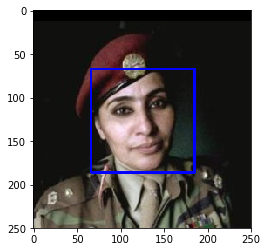

In [5]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [7]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Detect and count human faces found in 100 human face images
true_positive_count=0
for img in human_files_short:
    detected = face_detector(img)
    if(detected):
        true_positive_count+=1
        
# Detect and count human faces found in 100 dog face images        
false_positive_count=0
for img in dog_files_short:
    detected = face_detector(img)
    if(detected):
        false_positive_count+=1
    
print("True positives in 100 human faces =",true_positive_count,"%")
print("False positives in 100 dog faces =",false_positive_count,"%")

True positives in 100 human faces = 100 %
False positives in 100 dog faces = 11 %


Answer:
    The opencv model has been trained to discriminate between target(human) and non target images. It has not been trained to using pictures of dogs so it unreasonable to expect it perform well at this task. The documentation provides a little background on the training of the model.   
[Opencv model training documentation](https://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html)

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

The application  needs to be considered then design decisions made to deliver the business case specified. Any limitations of the software app need to be understood by the business or customer of the app.  
If a app is required to identify partial faces then it needs to be designed and trained for this purpose. The human face dataset presented here is separated into classes by person name so it seems that it has been designed with facial personal identfication in mind not simply human or not recognition.  In an application say facial recognition based security it is reasonable to mandate user present head on facial images for evaluation.


***

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

### (Optional) TODO: Report the performance of another  
### face detection algorithm on the LFW dataset
#### Feel free to use as many code cells as needed.

In [8]:
def display_image(img_path, title='image'):   
    """
    Show the image stored at path with title
    Args:
    img_path (string): pathname of file to make prediction for
    title (string): title of image displayed
    Returns:
    axs (plt.Axis): Axis of image displayed
    """
    fig, axs = plt.subplots(figsize=(6,6))
    axs.imshow(np.array(PIL.Image.open(img_path)))
    axs.axis('off')
    axs.set_title(title)
    plt.show()
    return axs

In [9]:
# Human face dataset human_files
print("human_files dataset shape =",human_files.shape)
# Check dimensions of images
for img in human_files:
    width,height=PIL.Image.open(img).size
    if(width!=250 or height!=250):
        print ('Wrong size!')

human_files dataset shape = (13233,)


In [10]:
#dog_files_all = np.append(train_files, values=[valid_files, test_files])

dog_files_all=[]
dog_files_all.extend(train_files)
dog_files_all.extend(valid_files)
dog_files_all.extend(test_files)
print("Number of dog files",len(dog_files_all))

Number of dog files 8351


In [11]:
# Check dog image sizes
dog_sizes_df = pd.DataFrame(columns=['width','height'])
dog_sizes_df = dog_sizes_df.astype({'width':np.float64,'height':np.float64})
for dog_img in dog_files_all:

    width, height = PIL.Image.open(dog_img).size
    dog_sizes_df = dog_sizes_df.append({'width': width,'height':height}, ignore_index=True)
    #print(width,height)
    
# Dog image sizes are assorted
dog_sizes_df.describe()

,width,height
count,8351.000000,8351.000000
mean,567.032571,529.044905
std,389.006647,333.197594
min,105.000000,113.000000
25%,375.000000,360.000000
50%,500.000000,467.000000
75%,640.000000,600.000000
max,4278.000000,4003.000000


There are 13233 human face files, they have already been randomly shuffled so I don't need to do that again. All the human face images are 250 x 250 pixels in size the dog images are assorted sizes
[Open face](https://opencv.org)

In [12]:
#There are 8351 dog images and 13233 human

# I need to restrict number and size of images to avoid memory limitation issues.
# 1500 Human 1500 Dog images classes are balanced 50/50 
num_images=1500
img_size=250
num_classes=2
num_epoch=20
K.set_image_dim_ordering('th')
# Create dataset of human and dog images dog first then human
hd_files = np.append(dog_files_all[:num_images],values=[human_files[:num_images]])

nsamples=len(hd_files)
print('nsamples=',nsamples)
print("image data shape",hd_files.shape,)

nsamples= 3000
image data shape (3000,)


In [13]:
def preprocess_images(img_files, img_size):
    img_data=[]
    for img_path in img_files:
        input_img=cv2.imread(img_path)
        input_img=cv2.resize(input_img,(img_size, img_size), interpolation = cv2.INTER_AREA)
        img_data.append(input_img)
    
    img_data=np.array(img_data)
    img_data = img_data.astype('float32')
    img_data /= 255
    return img_data
    
img_data = preprocess_images(hd_files, img_size)

In [14]:
# Setup labels
names=['dog','human']
labels = np.zeros((nsamples,), dtype='int32')

labels[:num_images]=0 # Dogs
labels[num_images:]=1 # Humans

In [15]:
img_data.shape

(3000, 250, 250, 3)

In [16]:
if K.image_dim_ordering()=='th':
    img_data=np.rollaxis(img_data,3,1)
    print (img_data.shape)

(3000, 3, 250, 250)


In [17]:
# convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=42)
# Split the dataset
X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
print("X_train shape",X_train_hd.shape)
print("y_train shape",y_train_hd.shape)

X_train shape (2400, 3, 250, 250)
y_train shape (2400, 2)


### Build Model

In [20]:
# Human/Dog Detector
input_shape=img_data[0].shape

model = Sequential() # keras Sequential model


model.add(Conv2D(32,(3,3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Dropout(0.5))


model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

In [21]:
# Display Model Summary
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 250, 250)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 250, 250)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 248, 248)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 248, 248)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 124, 124)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 124, 124)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 122, 122)      18496     
__________

True

In [22]:
start=time.time()

model1_savepath='saved_models/weights.best.model1.hdf5'

checkpointer = ModelCheckpoint(filepath=model1_savepath, 
                               verbose=1, save_best_only=True)
# Training
hist = model.fit(X_train_hd, y_train_hd, batch_size=20, epochs=num_epoch, verbose=1,
                 validation_data=(X_test_hd, y_test_hd), callbacks=[checkpointer])

end=time.time()
print('Time Elapsed: ', (end-start)/60,"mins")

Train on 2400 samples, validate on 600 samples
Epoch 1/20
2400/2400 [==============================] - 116s 48ms/step - loss: 0.5498 - acc: 0.7763 - val_loss: 0.1981 - val_acc: 0.9600
Epoch 2/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.2405 - acc: 0.9192 - val_loss: 0.2730 - val_acc: 0.9267
Epoch 3/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.1778 - acc: 0.9408 - val_loss: 0.0907 - val_acc: 0.9800
Epoch 4/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.1390 - acc: 0.9583 - val_loss: 0.3627 - val_acc: 0.8250
Epoch 5/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.0942 - acc: 0.9704 - val_loss: 0.0750 - val_acc: 0.9800
Epoch 6/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.0991 - acc: 0.9758 - val_loss: 0.1589 - val_acc: 0.9450
Epoch 7/20
2400/2400 [==============================] - 113s 47ms/step - loss: 0.1165 - acc: 0.9754 - val_loss: 0.1039 - val_acc: 0

In [23]:
# Load best weights
model.load_weights(model1_savepath)

In [24]:
human_test = preprocess_images(human_files_short, img_size)
dog_test = preprocess_images(dog_files_short,img_size)

if K.image_dim_ordering()=='th':
    human_test=np.rollaxis(human_test,3,1)
    print (human_test.shape)
    
if K.image_dim_ordering()=='th':
    dog_test=np.rollaxis(dog_test,3,1)
    print (dog_test.shape)

(100, 3, 250, 250)
(100, 3, 250, 250)


In [25]:
# Make predictions for the human and dog short datasets
human_preds = model.predict_classes(human_test,verbose=1)
dog_preds = model.predict_classes(dog_test,verbose=1)

100/100 [==============================] - 0s 3ms/step


In [26]:
human_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
# Count of number of humans classified as human in human_files_short
print(human_preds.sum())

98


In [28]:
dog_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
# Count of number of dogs in dog_files_short classified as humans
print(dog_preds.sum())

0


So the number of non human images not correctly classified is now 1 down from 11.  Both algorithms have 100% of humans correctly identified.
This is an improvement in performance over the OpenCV haarcascades model for detecting faces. It is trained on the human and dog data that we have here.

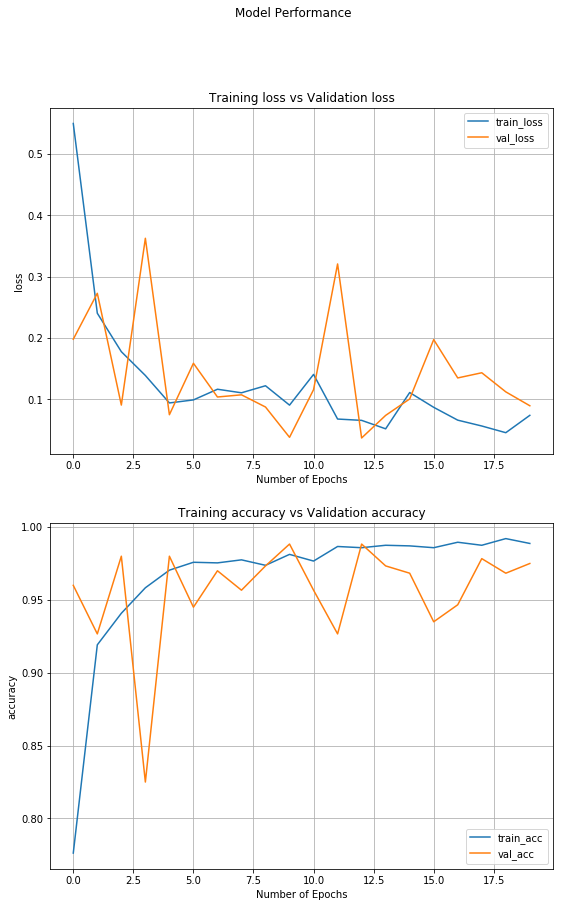

In [30]:
# Visualizing model performance
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

fig,axs = plt.subplots(2,figsize=(9,14))
fig.suptitle('Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(xc,train_loss)
axs[0].plot(xc,val_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('loss')
axs[0].set_title('Training loss vs Validation loss')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(xc,train_acc)
axs[1].plot(xc,val_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Training accuracy vs Validation accuracy')
axs[1].grid(True)
axs[1].legend(['train_acc','val_acc'],loc=4)

plt.show()

In [31]:
# Switch back to tensorflow channel last order
K.set_image_dim_ordering('tf')

In [32]:
model_save_path='saved_models/model_saved_human.hd5'

model.save_weights(model_save_path)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [33]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [35]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [37]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_detect(path_list):
    """
    Args:
    path_list (list): list of pathnames of image files
    Returns:
    cnt (int):Count of number of dogs found
    """
    cnt=0
    for imgpath in path_list:
        if(dog_detector(imgpath)):
            cnt+=1
    return cnt

In [38]:
print("Dogs detected in human_files_short",dog_detect(human_files_short),"%")
print("Dogs detected in dog_files_short",dog_detect(dog_files_short),"%")

Dogs detected in human_files_short 0 %
Dogs detected in dog_files_short 100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 6680/6680 [01:38<00:00, 67.87it/s] 


In [9]:
# Calculate Class Weights

train_class_labels = np.argmax(train_targets, axis=1)
train_class_weights = class_weight.compute_class_weight('balanced', np.unique(train_class_labels), train_class_labels)

class_weights_dict={}
for m in range(0,num_classes):
    class_weights_dict[m]=train_class_weights[m]
    
train_class_weights=class_weights_dict

valid_class_labels = np.argmax(valid_targets, axis=1)

valid_class_weights = class_weight.compute_class_weight('balanced', np.unique(valid_class_labels), valid_class_labels)

class_weights_dict={}
for m in range(0,num_classes):
    class_weights_dict[m]=valid_class_weights[m]

valid_sample_weights = class_weight.compute_sample_weight(class_weights_dict, valid_class_labels )

test_class_labels = np.argmax(test_targets, axis=1)

test_class_weights = class_weight.compute_class_weight('balanced', np.unique(test_class_labels), test_class_labels)


class_weights_dict={}
for m in range(0,num_classes):
    class_weights_dict[m]=test_class_weights[m]

test_sample_weights = class_weight.compute_sample_weight(class_weights_dict, test_class_labels )



### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
The data is presented in a 4 dimensional tensor (nsamples,3 channels of pixel values, x spatial , y spatial )
This architecture has cyles of Convolution + Relu Activation, followed by pooling. The CNN assigns significance to features of the image by creating trainable weights and biases.


Summary of model architecture
First Convolution + Relu activation

Second Convolution + Relu activation  and Pooling and Drop out

Third Convolution + Relu activation and Pooling and Drop out

Finally Prepare for Classification into a specified number of classes

#### Convolution
    Extracts high level features e.g. edges of subject in image
    Reduces dimensionality (Number of bits to stored and computed)
    
#### Activation

    Implements activation function in this layer.
    ReLU Can be applied as matix operation handly as arguments are tensors.
    Performs non linear transformation of input data. Non linear tranform hopes to make processed data linearly separable for       classificaton.
    ReLU Rectified Linear Unit  function will a) if input is positive output same as input, b) if input is negative output         zero. ReLU simplfies and speeds up learning as output gradient is 0 or 1.
    ReLU does not suffer from vanishing gradient, unlike log,tanh,erf functions.
#### Pooling

    Reduces dimensionality (Number of bits to be stored and computed) so reduces resource requirements of CNN algorithm.
    Extracts dominant features  (Max pooling returns the maximum value from a portion of the input image or processed tensor)
    Max pooling acts as noise suppressant.
#### Dropout 

    Provides regularization of input, reduces overfitting of data.
    Requires large network so that some learning occurs even if we throw away half the input to dropout layer.
    Requires use of weight contraint.
    
#### Dense
    This is a Fully connected layer. 
    Implements weights and bias that are basis of ML facilitate back propagation to implement learning. 
    Facilitates non linear combination of features.
    units argument defines output dimensions
   
#### Flatten
    Reshapes data before classification

#### Softmax
    The softmax classification technique makes the classification. It determines which class is identified in the output.
    
In summary this combination of layers implements deep learning and should provide learning while reducing overfitting. It implements CNN algorithm to provide feature extraction and classification of the samples input.


In [7]:
train_tensors.shape

NameError: name 'train_tensors' is not defined

In [43]:
# Build Dog Breed Classification Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

input_shape=train_tensors[0].shape
num_classes=133

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(32,(3,3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Dropout(0.5))


model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_score,"accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_55 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_56 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 222, 111, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 222, 111, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 220, 109, 64)      9280      
__________

In [45]:
from metrics_utility import f1_score

### Compile the Model

In [49]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[f1_score,'accuracy'], weighted_metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [52]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 15 


### Do NOT modify the code below this line.
start=time.time()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

hist=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets, valid_sample_weights),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], class_weight=train_class_weights, verbose=1)
end=time.time()
print('Time Elapsed: ', (end-start)/60,"mins")

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 76s 11ms/step - loss: 5.9861 - custom_f1: 6.0668e-04 - acc: 0.0073 - weighted_acc: 0.0073 - val_loss: 4.8844 - val_custom_f1: 0.0000e+00 - val_acc: 0.0108 - val_weighted_acc: 0.0108
Epoch 2/15
6680/6680 [==============================] - 73s 11ms/step - loss: 4.8863 - custom_f1: 0.0000e+00 - acc: 0.0093 - weighted_acc: 0.0093 - val_loss: 4.8780 - val_custom_f1: 0.0000e+00 - val_acc: 0.0156 - val_weighted_acc: 0.0156
Epoch 3/15
6680/6680 [==============================] - 73s 11ms/step - loss: 4.8627 - custom_f1: 0.0000e+00 - acc: 0.0142 - weighted_acc: 0.0142 - val_loss: 4.8437 - val_custom_f1: 0.0000e+00 - val_acc: 0.0132 - val_weighted_acc: 0.0132
Epoch 4/15
6680/6680 [==============================] - 73s 11ms/step - loss: 4.8008 - custom_f1: 0.0000e+00 - acc: 0.0169 - weighted_acc: 0.0169 - val_loss: 4.7590 - val_custom_f1: 0.0000e+00 - val_acc: 0.0168 - val_weighted_acc: 0.0168
E

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
# Visualizing model performance
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(epochs)

fig,axs = plt.subplots(2,figsize=(9,14))
fig.suptitle('Model Performance')
fig.patch.set_facecolor('w')

axs[0].plot(xc,train_loss)
axs[0].plot(xc,val_loss)
axs[0].set_xlabel('Number of Epochs')
axs[0].set_ylabel('loss')
axs[0].set_title('Training loss vs Validation loss')
axs[0].grid(True)
axs[0].legend(['train_loss','val_loss'])
axs[0].set_facecolor('w')

axs[1].plot(xc,train_acc)
axs[1].plot(xc,val_acc)
axs[1].set_xlabel('Number of Epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Training accuracy vs Validation accuracy')
axs[1].grid(True)
axs[1].legend(['train_acc','val_acc'],loc=4)

plt.show()

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [ ]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

### Compile the Model

In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [ ]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

networks=['VGG16','VGG19','ResNet50','InceptionV3','Xception']

network=networks[2]

data_pathname='bottleneck_features/Dog{network}Data.npz'.format(network=network)

print("Loading",data_pathname)
      
bottleneck_features = np.load(data_pathname)

train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [ ]:
# Generalize the input tensors so I can change this
train_bnf = train_ResNet50
valid_bnf = valid_ResNet50
test_bnf = test_ResNet50

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


#### Input

We need a input layer that will accept our 4D tensors for nsamples. The image_to_tensor function defines the shape we only need one shape'

#### Flatten

The flatten layer converts the input a 2 dimensional tensor for the dense layer to process.

#### Dense

Implements dense layer with input_shape specified and softmax activation algorithm attached to make classification with the correct number of classes. 133 dog breeds. It receives the data and applies the softmax to make the classification.

This arrangment is a basic logistic regression.
    




In [ ]:
# Display shape of input tensors
print(train_bnf.shape)
print(valid_bnf.shape)
print(test_bnf.shape)

In [ ]:
input_obj = keras.Input(shape=train_bnf.shape[1:])
flatten_layer = Flatten()(input_obj)
dense_layer = Dense(num_classes, activation='softmax')(flatten_layer)
model2=keras.Model(input_obj, dense_layer)

model2.summary()

### (IMPLEMENTATION) Compile the Model

In [ ]:
### TODO: Compile the model.

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
### TODO: Train the model.


saved_pathname='saved_models/weights.best.{network}.hdf5'.format(network=network)
print("Best saved file pathname",saved_pathname)

checkpointer = ModelCheckpoint(filepath=saved_pathname, 
                               verbose=1, save_best_only=True)

hist=model2.fit(train_bnf, train_targets, 
          validation_data=(valid_bnf, valid_targets),
          epochs=20, batch_size=30, callbacks=[checkpointer], verbose=1)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.

model2.load_weights(saved_pathname)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.

model2_preds = [np.argmax(model2.predict(np.expand_dims(feature, axis=0))) for feature in test_bnf]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model2_preds)==np.argmax(test_targets, axis=1))/len(model2_preds)
print('Test accuracy: %.4f%%' % test_accuracy)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
# extract_bottleneck_features functions

#extract_VGG16
#extract_VGG19
#extract_Resnet50
#extract_Xception
#extract_InceptionV3

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

#import bottleneck features api
import extract_bottleneck_features as ebf



def identify_breed(img_pathname, model2=model2):
    
    # Extract bottleneck features
    bottleneck_feature = ebf.extract_Resnet50(path_to_tensor(img_pathname))
    # Make prediction for this
    predicted_vector = model2.predict(bottleneck_feature)
    # return the breed name predicted by the model
    breed_name= dog_names[np.argmax(predicted_vector)]
    return breed_name

In [ ]:
test_classes=np.argmax(test_targets, axis=1)

In [ ]:
# Confusion Matrix   Rows are test classes Columns are predictions
con_matrix=confusion_matrix(y_true=test_classes, y_pred= model2_preds,  labels=None, sample_weight=None)

In [ ]:

import seaborn as sns; 

plt.figure(figsize=(13,10))
axs = plt.axes()
axs.set_title('Confusion Matrix')
axs.set_xlabel('fudge')
axs.set_xlabel('fudge')
sns.heatmap(con_matrix, annot=False, cmap="Blues", ax=axs)

In [ ]:
cm_df=pd.DataFrame(con_matrix)

In [ ]:
def get_name(indx):
    return dog_names[indx]

In [ ]:
error_df = pd.DataFrame(columns=['x_index','y_index','count'])

for x in range(0,133):
    for y in range(0,133):
        if(x!=y and con_matrix[x,y]!=0):
            #print(x,y,con_matrix[x,y])
            error_df= error_df.append({'x_index':x,'y_index':y,'count':con_matrix[x,y]}, ignore_index=True)



repeated_errors=error_df.sort_values(['count'],ascending=False).head(20)
repeated_errors['x_name'] = repeated_errors['x_index'].apply(lambda x : get_name(x)) 
repeated_errors['y_name'] = repeated_errors['y_index'].apply(lambda y : get_name(y)) 

In [ ]:
repeated_errors

In [ ]:
for index, row in repeated_errors.head(5).iterrows():
    msg_part1='Predicted dog was a {x_name}, but really it was a {y_name}, {count} times.'
    msg=msg_part1.format(x_name=row['x_name'], y_name=row['y_name'], count=row['count'])
    print(msg)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.




def dog_breed_predictor(img_path):
    """
    Args:
    img_path (string): pathname of file to make prediction for
    Returns:
    breed_name (string): Name of breed
    """
    result=""
    if(dog_detector(img_path)):
        result=identify_breed(img_path)
        print( "This is a dog, its breed is", result)
    elif(face_detector(img_path)):
        result=identify_breed(img_path)
        print("This is a human, looks similar to a ", result)
    else:
        result="Not dog or human"
        print("This does not look like Human or Dog!")
    return result

def show_predicted_breed(img_path):
    """
    Show the image stored at path with the predicted result as title
    Args:
    img_path (string): pathname of file to make prediction for
    """
    print("Actual image path = ", img_path)
    
    display_image(img_path, dog_breed_predictor(img_path))

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is better than I expected
1. The algoritm could be improved by training for longer
2. The algoritm cound be improve by adding layers to make it deeper.
3. The algorithm could be improved by augmenting images, adding more images would help too. If possible improve the quality of the images. No images with people as well as dogs no dogs in clothes unless that is really what you want to train on. Standardize images lighting colour balance etc

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [ ]:
test_images=['American_water_spaniel_00648.jpg',
'Brittany_02625.jpg',
'Curly-coated_retriever_03896.jpg',
'human_face.jpg',
'Labrador_retriever_06449.jpg',
'Labrador_retriever_06455.jpg',
'Labrador_retriever_06457.jpg',
'sample_cnn.png',
'sample_dog_output.png',
'sample_human_2.png',
'sample_human_output.png',
'Welsh_springer_spaniel_08203.jpg',
'lara.jpg']

print("Number of images=",len(test_images))


def get_image(index):
    return 'images/{img}'.format(img=test_images[index])


In [ ]:
import dog_app_utils
sb=Scoreboard()

In [ ]:
show_predicted_breed(get_image(0))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='American Water Spaniel',breedPred='Boykin Spaniel')

The american water spaniel and Boykin Spaniel look very similar. So it not suprising the algorithm got this wrong.

[Spot the difference](https://nationalpurebreddogday.com/the-boykin-spaniel-and-the-american-water-spaniel-differences/)

In [ ]:
show_predicted_breed(get_image(1))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Brittany',breedPred='Brittany')

In [ ]:
show_predicted_breed(get_image(2))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Curly-coated_retriever',breedPred='Curly-coated_retriever')

In [ ]:
show_predicted_breed(get_image(3))

In [ ]:
sb.set_dog_detector_score(isDogActual=False,isDogPred=False)
sb.set_human_detector_score(isHumanActual=True,isHumanPred=False)

In [ ]:
show_predicted_breed(human_files_short[0])

The original image works better than the processed on presumably because the algorithm was trained on original images.

In [ ]:
sb.set_dog_detector_score(isDogActual=False,isDogPred=False)
sb.set_human_detector_score(isHumanActual=True,isHumanPred=True)

In [ ]:
show_predicted_breed(get_image(4))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Labrador_retriever',breedPred='Labrador_retriever')

In [ ]:
show_predicted_breed(get_image(5))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Labrador_retriever',breedPred='Labrador_retriever')

In [ ]:
show_predicted_breed(get_image(6))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Labrador_retriever',breedPred='Labrador_retriever')

In [ ]:
show_predicted_breed(get_image(7))

In [ ]:
sb.set_dog_detector_score(isDogActual=False,isDogPred=False)
sb.set_human_detector_score(isHumanActual=False,isHumanPred=False)

In [ ]:
show_predicted_breed(get_image(8))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=False)
sb.set_human_detector_score(isHumanActual=False,isHumanPred=False)

In [ ]:
show_predicted_breed(get_image(9))

In [ ]:
sb.set_dog_detector_score(isDogActual=False,isDogPred=False)
sb.set_human_detector_score(isHumanActual=True,isHumanPred=True)

In [ ]:
show_predicted_breed(get_image(10))

In [ ]:
sb.set_dog_detector_score(isDogActual=False,isDogPred=False)
sb.set_human_detector_score(isHumanActual=True,isHumanPred=True)

In [ ]:
show_predicted_breed(get_image(11))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Welsh_springer_spaniel',breedPred='Welsh_springer_spaniel')


In [ ]:
show_predicted_breed(get_image(12))

In [ ]:
sb.set_dog_detector_score(isDogActual=True,isDogPred=True)
sb.set_dog_breed_detector_score(breedActual='Golden_Retriever',breedPred='Golden_Retriever')

In [ ]:
# Display truth table
sb.print_out()

- TP - True Positive
- TN - True Negative
- FP - False Positive
- FN - False Negative

So 3 False Negatives out of 28 decisions thats not bad.